<a href="https://colab.research.google.com/github/tndls2/AI/blob/main/ResNext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy
     

# Load Dataset

In [ ]:
# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define transformations for the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the FashionMNIST training and test data
trainset = datasets.FashionMNIST('MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('MNIST_data/', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

print(len(trainloader))
print(len(testloader))

100%|██████████| 26421880/26421880 [00:01<00:00, 14904834.86it/s]


Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 266819.44it/s]


Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5073354.20it/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5930315.02it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw

938
157


# Model

참고 : https://github.com/Seonghoon-Yu/AI_Paper_Review/tree/master/Classification

In [ ]:
class BottleNeck(nn.Module):
    expansion = 4
    Cardinality = 32 # group 수
    Basewidth = 64 # bottleneck 채널이 64이면 group convolution의 채널은 depth가 됩니다.
    Depth = 4 # basewidth일 때, group convolution의 채널 수
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        C = BottleNeck.Cardinality
        D = int(BottleNeck.Depth * out_channels / BottleNeck.Basewidth)

        self.conv_residual = nn.Sequential(
            nn.Conv2d(in_channels, C * D, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(C*D),
            nn.ReLU(),
            nn.Conv2d(C*D, C*D, 3, stride=stride, padding=1, groups=BottleNeck.Cardinality, bias=False),
            nn.BatchNorm2d(C*D),
            nn.ReLU(),
            nn.Conv2d(C*D, out_channels * BottleNeck.expansion, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion)
        )

        self.conv_shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.conv_shortcut = nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, 1, stride=stride, padding=0)

    def forward(self, x):
        x = self.conv_residual(x) + self.conv_shortcut(x)
        return x

In [ ]:
# ResNext
class ResNext(nn.Module):
    def __init__(self, nblocks, num_classes=10, init_weights=True):
        super().__init__()
        self.init_weights=init_weights
        self.in_channels = 64

        self.conv1 = nn.Sequential(
            # 입력 채널 수를 1로 설정
            nn.Conv2d(1, 64, 7, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=1)
        )

        self.conv2 = self._make_res_block(nblocks[0], 64, 1)
        self.conv3 = self._make_res_block(nblocks[1], 128, 2)
        self.conv4 = self._make_res_block(nblocks[2], 256, 2)
        self.conv5 = self._make_res_block(nblocks[3], 512, 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(512 * BottleNeck.expansion, num_classes)

        # weights initialization
        if self.init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

    def _make_res_block(self, nblock, out_channels, stride):
        strides = [stride] + [1] * (nblock-1)
        res_block = nn.Sequential()
        for i, stride in enumerate(strides):
            res_block.add_module('dens_layer_{}'.format(i), BottleNeck(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * BottleNeck.expansion
        return res_block

    # weights initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def ResNext50():
    return ResNext([3, 4, 6, 3])

In [ ]:
model = ResNext50().to(device)
x = torch.randn((64,1, 28, 28)).to(device)
output = model(x)
print('output size: ', output.size())
     


output size:  torch.Size([64, 10])


In [ ]:
# print summary
summary(model, (1, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 111, 111]           3,136
       BatchNorm2d-2         [-1, 64, 111, 111]             128
              ReLU-3         [-1, 64, 111, 111]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]           4,608
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          32,768
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,640
       BottleNeck-14          [-1, 256,

# Train&Test

In [ ]:
# define loss function, optimizer, lr_scheduler
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.SGD(model.parameters(), lr=0.01)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)


# get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


# calculate the metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# calculate the loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item(), metric_b


# calculate the loss per epochs
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric

# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    trainloader=params['trainloader']
    testloader=params['testloader']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, trainloader, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, testloader, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [ ]:
# define the training parameters
params_train = {
    'num_epochs':100,
    'optimizer':opt,
    'loss_func':loss_func,
    'trainloader':trainloader,
    'testloader':testloader,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# check the directory to save weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')
     

In [ ]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/99, current lr= 0.01
train loss: nan, val loss: nan, accuracy: 10.00, time: 0.8843 min
----------
Epoch 1/99, current lr= 0.01
train loss: nan, val loss: nan, accuracy: 10.00, time: 1.7534 min
----------
Epoch 2/99, current lr= 0.01
train loss: nan, val loss: nan, accuracy: 10.00, time: 2.6266 min
----------
Epoch 3/99, current lr= 0.01
train loss: nan, val loss: nan, accuracy: 10.00, time: 3.4942 min
----------
Epoch 4/99, current lr= 0.01
train loss: nan, val loss: nan, accuracy: 10.00, time: 4.3593 min
----------
Epoch 5/99, current lr= 0.01
train loss: nan, val loss: nan, accuracy: 10.00, time: 5.2546 min
----------
Epoch 6/99, current lr= 0.01
train loss: nan, val loss: nan, accuracy: 10.00, time: 6.1389 min
----------
Epoch 7/99, current lr= 0.01
train loss: nan, val loss: nan, accuracy: 10.00, time: 7.0141 min
----------
Epoch 8/99, current lr= 0.01
train loss: nan, val loss: nan, accuracy: 10.00, time: 7.9042 min
----------
Epoch 9/99, current lr= 0.01
train loss: nan, 

# Evaluation

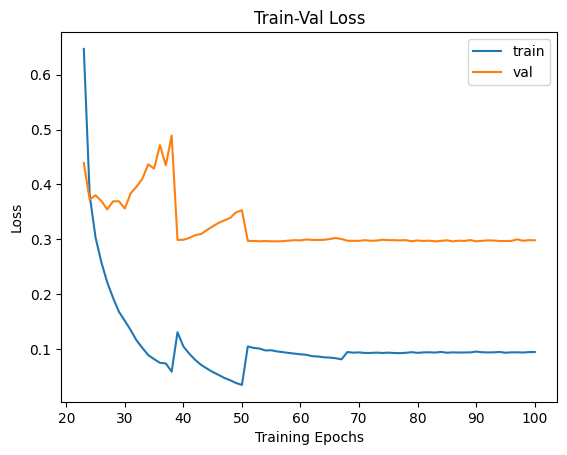

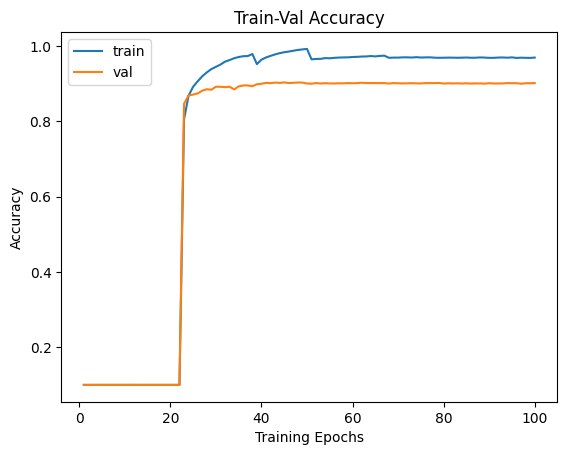

In [ ]:
# train-val progress
num_epochs = params_train['num_epochs']

# plot loss progress
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot accuracy progress
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

In [ ]:

# 정확도를 추적할 변수 초기화
top1_correct = 0
top5_correct = 0
total_samples = 0

# 테스트 데이터셋을 사용하여 정확도 계산
model.eval()  # 평가 모드로 설정

with torch.no_grad():  # 그래디언트 추적 비활성화
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)

        # 모델에 입력 데이터 전달
        outputs = model(images)

        # top-1 및 top-5 예측 추출
        _, predicted = torch.max(outputs, 1)
        _, top5_predicted = torch.topk(outputs, 5, dim=1)

        # 정확한 예측 수 계산
        top1_correct += (predicted == labels).sum().item()
        top5_correct += sum(labels[i] in top5_predicted[i] for i in range(len(labels)))
        total_samples += labels.size(0)

# 정확도 계산
top1_accuracy = top1_correct / total_samples
top5_accuracy = top5_correct / total_samples

# 결과 출력
print(f"Top-1 Accuracy: {top1_accuracy * 100:.2f}%")
print(f"Top-5 Accuracy: {top5_accuracy * 100:.2f}%")

Top-1 Accuracy: 89.99%
Top-5 Accuracy: 99.85%


In [ ]:
!pip install ptflops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ptflops: filename=ptflops-0.7-py3-none-any.whl size=11076 sha256=075907348fb8dab5d7b7f680e63f6596af70d8b117b58d4a4a2c832a3aa4ec82
  Stored in directory: /root/.cache/pip/wheels/b9/54/3b/f84523431ce82e08462644d279c0e13a51a00236e237e6bc7e
Successfully built ptflops


In [ ]:
import torchvision.models as models
import torch
from ptflops import get_model_complexity_info

with torch.cuda.device(0):
    net = model
    macs, params = get_model_complexity_info(net, (1, 224, 224), as_strings=True,
                                             print_per_layer_stat=True, verbose=True)
    print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
    print('{:<30}  {:<8}'.format('Number of parameters: ', params))

ResNext(
  22.99 M, 100.000% Params, 4.18 GMac, 100.000% MACs, 
  (conv1): Sequential(
    3.26 k, 0.014% Params, 41.79 MMac, 0.999% MACs, 
    (0): Conv2d(3.14 k, 0.014% Params, 38.64 MMac, 0.923% MACs, 1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(128, 0.001% Params, 1.58 MMac, 0.038% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 788.54 KMac, 0.019% MACs, )
    (3): MaxPool2d(0, 0.000% Params, 788.54 KMac, 0.019% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    205.57 k, 0.894% Params, 647.07 MMac, 15.463% MACs, 
    (dens_layer_0): BottleNeck(
      63.23 k, 0.275% Params, 199.1 MMac, 4.758% MACs, 
      (conv_residual): Sequential(
        46.59 k, 0.203% Params, 146.92 MMac, 3.511% MACs, 
        (0): Conv2d(8.19 k, 0.036% Params, 25.69 MMac, 0.614% MACs, 64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): Ba